In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from dataclasses import dataclass
import utils
from torch_geometric_temporal import  DynamicGraphTemporalSignal,StaticGraphTemporalSignal, temporal_signal_split, DynamicGraphTemporalSignalBatch
import networkx as nx
from torch_geometric.utils import from_networkx
import scipy
import sklearn
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.loader import DynamicBatchSampler,DataLoader
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.ops import sigmoid_focal_loss
from torch_geometric_temporal.nn.recurrent import DCRNN,  GConvGRU, A3TGCN, TGCN2
from torch_geometric_temporal.nn.attention import STConv
from torchmetrics.classification import BinaryRecall, AUROC, ROC
from torch_geometric.nn import global_mean_pool
import timeit
import pytorch_lightning as pl
from torch_geometric.nn import GCNConv,BatchNorm
from sklearn.model_selection import KFold,StratifiedKFold

In [ ]:
def plv_connectivity(sensors,data):
    """
    Parameters
    ----------
    sensors : INT
        DESCRIPTION. No of sensors used for capturing EEG
    data : Array of float 
        DESCRIPTION. EEG Data
    
    Returns
    -------
    connectivity_matrix : Matrix of float
        DESCRIPTION. PLV connectivity matrix
    connectivity_vector : Vector of flaot 
        DESCRIPTION. PLV connectivity vector
    """
    print("PLV in process.....")
    
    # Predefining connectivity matrix
    connectivity_matrix = np.zeros([sensors,sensors],dtype=float)
    
    # Computing hilbert transform
    data_points = data.shape[-1]
    data_hilbert = np.imag(scipy.signal.hilbert(data))
    phase = np.arctan(data_hilbert/data)
    
    # Computing connectivity matrix 
    for i in range(sensors):
        for k in range(sensors):
            connectivity_matrix[i,k] = np.abs(np.sum(np.exp(1j*(phase[i,:]-phase[k,:]))))/data_points
            
    # Computing connectivity vector
   # connectivity_vector = connectivity_matrix[np.triu_indices(connectivity_matrix.shape[0],k=1)] 
      
    # returning connectivity matrix and vector
    
    return connectivity_matrix

In [2]:
def create_recordings_plv(npy_dataset_path,dst_path):
    patient_list = os.listdir(npy_dataset_path)
    if not os.path.exists(dst_path):
        os.mkdir(dst_path)
    for patient in patient_list: # iterate over patient names
        patient_path = os.path.join(npy_dataset_path,patient)
        recording_list = os.listdir(patient_path)
        save_folder = os.path.join(dst_path,patient)
        if not os.path.exists(save_folder):
            os.mkdir(save_folder)
        for record in recording_list: # iterate over recordings for a patient
            recording_path = os.path.join(patient_path,record)
            data_array = np.load(recording_path) # load the recording
            starttime = timeit.default_timer()
            print(f'Calculating PLV for {record}')
            plv_array = plv_connectivity(data_array.shape[0],data_array)
            target_filename = os.path.join(save_folder,record)
            np.save(target_filename,plv_array)
            print("The time of calculation is :", timeit.default_timer() - starttime)

In [2]:
# TODO think about using kwargs argument here to specify args for dataloader
@dataclass
class SeizureDataLoader:
    npy_dataset_path :Path
    event_tables_path : Path
    plv_values_path : Path
    loso_patient : str = None
    sampling_f : int = 256
    seizure_lookback: int = 600
    sample_timestep: int = 5
    inter_overlap: int = 0
    ictal_overlap: int = 0
    self_loops : bool = True
    balance : bool = True
    train_test_split:  float = None
    
    """Class to prepare dataloaders for eeg seizure perdiction from stored files.

    Attributes:
        npy_dataset_path {Path} -- Path to folder with dataset preprocessed into .npy files.
        event_tables_path {Path} -- Path to folder with .csv files containing seizure events information for every patient.
        loso_patient {str} -- Name of patient to be selected for LOSO valdiation, specified in format "chb{patient_number}"",
        eg. "chb16". (default: {None}).
        samplin_f {int} -- Sampling frequency of the loaded eeg data. (default: {256}).
        seizure_lookback {int} -- Time horizon to sample pre-seizure data (length of period before seizure) in seconds. 
        (default: {600}).
        sample_timestep {int} -- Amounts of seconds analyzed in a single sample. (default: {5}).
        overlap {int} -- Amount of seconds overlap between samples. (default: {0}).
        self_loops {bool} -- Wheather to add self loops to nodes of the graph. (default: {True}).
        shuffle {bool} --  Wheather to shuffle training samples.


    """
    def _get_event_tables(self,patient_name : str) -> tuple[dict,dict]:
        """Read events for given patient into start and stop times lists from .csv extracted files."""

        event_table_list = os.listdir(self.event_tables_path)
        patient_event_tables = [os.path.join(self.event_tables_path,ev_table)
        for ev_table in event_table_list if patient_name in ev_table]
        patient_event_tables = sorted(patient_event_tables)
        patient_start_table = patient_event_tables[0] ## done terribly, but it has to be so for win/linux compat
        patient_stop_table = patient_event_tables[1]
        start_events_dict = pd.read_csv(patient_start_table).to_dict('index')
        stop_events_dict = pd.read_csv(patient_stop_table).to_dict('index')
        return start_events_dict,stop_events_dict
        
    def _get_recording_events(self,events_dict,recording) -> list[int]:
        """Read seizure times into list from event_dict"""
        recording_list = list(events_dict[recording+'.edf'].values())
        recording_events = [int(x) for x in recording_list if not np.isnan(x)]
        return recording_events


    def _get_graph(self,n_nodes: int) -> nx.Graph :
        """Creates Networx fully connected graph with self loops"""
        graph = nx.complete_graph(n_nodes)
        self_loops = [[node,node]for node in graph.nodes()]
        graph.add_edges_from(self_loops)
        return graph
    
    def _get_edge_weights_recording(self,plv_values: np.ndarray) ->np.ndarray:
        """Method that takes plv values for given recording and assigns them 
        as edge attributes to a fc graph."""
        graph = self._get_graph(plv_values.shape[0])
        garph_dict = {}
        for edge in graph.edges():
            e_start,e_end = edge
            garph_dict[edge] = {'plv':plv_values[e_start,e_end]}
        nx.set_edge_attributes(graph, garph_dict)
        edge_weights = from_networkx(graph).plv.numpy()
        return edge_weights
    
    def _get_edges(self):
        """Method to assign edge attributes. Has to be called AFTER get_dataset() method."""
        graph = self._get_graph(self._features.shape[1])
        edges = np.expand_dims(from_networkx(graph).edge_index.numpy(),axis=0)
        edges_per_sample_train = np.repeat(edges,repeats =self._features.shape[0],axis=0)
        self._edges = torch.tensor(edges_per_sample_train)
        if self.loso_patient is not None:
            edges_per_sample_val = np.repeat(edges,repeats =self._val_features.shape[0],axis=0)
            self._val_edges = torch.tensor(edges_per_sample_val)
       
    def _array_to_tensor(self):
        """Method converting features, edges and weights to torch.tensors"""
        self._features = torch.tensor(self._features)
        self._labels = torch.tensor(self._labels)
        self._time_labels = torch.tensor(self._time_labels)
        self._edge_weights = torch.tensor(self._edge_weights)
     
    
    def _val_array_to_tensor(self):
        self._val_features = torch.tensor(self._val_features)
        self._val_labels = torch.tensor(self._val_labels)
        self._val_time_labels = torch.tensor(self._val_time_labels)
        self._val_edge_weights = torch.tensor(self._val_edge_weights)
     
        
    def _get_labels_count(self):
        labels,counts = np.unique(self._labels,return_counts=True)
        self._label_counts = {}
        for n, label in enumerate(labels):
            self._label_counts[int(label)] = counts[n]
        
    def _get_val_labels_count(self):
        labels,counts = np.unique(self._val_labels,return_counts=True)
        self._val_label_counts = {}
        for n, label in enumerate(labels):
            self._val_label_counts[int(label)] = counts[n]
        
    def _balance_classes(self):
        negative_label = self._label_counts[0]
        positive_label = self._label_counts[1]
    
        imbalance = negative_label - positive_label
        negative_indices = np.where(self._labels == 0)[0]
        indices_to_discard = np.random.choice(negative_indices,size = imbalance,replace=False)

        self._features = np.delete(self._features,obj=indices_to_discard,axis=0)
        self._labels = np.delete(self._labels,obj=indices_to_discard,axis=0)
        self._time_labels = np.delete(self._time_labels,obj=indices_to_discard,axis=0)
        self._edge_weights = np.delete(self._edge_weights,obj=indices_to_discard,axis=0)

        
    def _get_labels_features_edge_weights(self):
        """Prepare features, labels, time labels and edge wieghts for training and 
        optionally validation data."""
        patient_list = os.listdir(self.npy_dataset_path)
        for patient in patient_list: # iterate over patient names
            event_tables = self._get_event_tables(patient) # extract start and stop of seizure for patient 
            patient_path = os.path.join(self.npy_dataset_path,patient)
            recording_list = os.listdir(patient_path)
            for record in recording_list: # iterate over recordings for a patient
                recording_path = os.path.join(patient_path,record)
                record_id = record.split('.npy')[0] #  get record id
                start_event_tables = self._get_recording_events(event_tables[0],record_id) # get start events
                stop_event_tables = self._get_recording_events(event_tables[1],record_id) # get stop events
                data_array = np.load(recording_path) # load the recording

                plv_edge_weights = np.expand_dims(
                    self._get_edge_weights_recording(
                        np.load(os.path.join(self.plv_values_path,patient,record))
          
                ),
                axis = 0
                )

                ##TODO add a gateway to reject seizure periods shorter than lookback
                # extract timeseries and labels from the array
                features,labels,time_labels = utils.extract_training_data_and_labels(
                    data_array,
                    start_event_tables,
                    stop_event_tables,
                    fs = self.sampling_f,
                    seizure_lookback = self.seizure_lookback,
                    sample_timestep = self.sample_timestep,
                    inter_overlap = self.inter_overlap,
                    ictal_overlap = self.ictal_overlap
                )
                
                time_labels = np.expand_dims(time_labels.astype(np.int32),1)
                labels = labels.reshape((labels.shape[0],1)).astype(np.float32)
            
                if patient == self.loso_patient:
                    try:
                        self._val_features = np.concatenate((self._val_features, features))
                        self._val_labels = np.concatenate((self._val_labels, labels))
                        self._val_time_labels = np.concatenate((self._val_time_labels , time_labels))
                        self._val_edge_weights = np.concatenate((
                            self._val_edge_weights,
                            np.repeat(plv_edge_weights,features.shape[0],axis=0)
                            ))
                    except:
                        self._val_features = features
                        self._val_labels = labels
                        self._val_time_labels = time_labels
                        self._val_edge_weights = np.repeat(plv_edge_weights,features.shape[0],axis=0)
                else:
                    try:
                        self._features = np.concatenate((self._features, features))
                        self._labels = np.concatenate((self._labels, labels))
                        self._time_labels = np.concatenate((self._time_labels , time_labels))
                        self._edge_weights = np.concatenate((
                            self._edge_weights,
                            np.repeat(plv_edge_weights,features.shape[0],axis=0)
                        ))
                       
                    except:
                        print("Creating initial attributes")
                        self._features = features
                        self._labels = labels
                        self._time_labels = time_labels
                        self._edge_weights = np.repeat(plv_edge_weights,features.shape[0],axis=0)
                
        
    # TODO define a method to create edges and calculate plv to get weights
    def get_dataset(self) -> DynamicGraphTemporalSignal:

        """Creating graph data iterators. The iterator yelds dynamic, weighted and undirected graphs
        containing self loops. Every node represents one electrode in EEG. The graph is fully connected,
        edge weights are calculated for every EEG recording as PLV between channels (edge weight describes 
        the "strength" of connectivity between two channels in a recording). Node features are values of 
        channel voltages in time. Features are of shape [nodes,features,timesteps].

        Returns:
            train_dataset {DynamicGraphTemporalSignal} -- Training data iterator.
            valid_dataset {DynamicGraphTemporalSignal} -- Validation data iterator (only if loso_patient is
            specified in class constructor).
        """
        ### TODO rozkminić o co chodzi z tym całym time labels - na razie wartość liczbowa która tam wchodzi
        ### to shape atrybutu time_labels
        
        self._get_labels_features_edge_weights()
        if self.balance:
            self._get_labels_count()
            self._balance_classes()
        self._get_edges()
        self._get_labels_count()
        
        self._array_to_tensor()
        
        train_dataset = torch.utils.data.TensorDataset(
        self._features, self._edges, self._edge_weights, self._labels,  self._time_labels
        )
        if self.train_test_split is not None:
            train_dataset, val_dataset = torch.utils.data.random_split(
                train_dataset,[1-self.train_test_split,self.train_test_split]
            )
            
            train_dataloader = torch.utils.data.DataLoader(
                train_dataset, batch_size = 16,shuffle = True,num_workers=2,pin_memory = True, prefetch_factor = 30,
                drop_last=True
            )
            
            val_dataloader = torch.utils.data.DataLoader(
                val_dataset, batch_size = 16,shuffle = False,num_workers=2,pin_memory = True, prefetch_factor = 30,
                drop_last=True
            )
            loaders = [train_dataloader,val_dataloader]
        else:
            train_dataloader = torch.utils.data.DataLoader(
                train_dataset, batch_size = 16,shuffle = True,num_workers=2,pin_memory = True, prefetch_factor = 30,
                drop_last=True
            )
            loaders = [train_dataloader]
        if self.loso_patient:
            self._get_val_labels_count()
            self._val_array_to_tensor()
            loso_dataset = torch.utils.data.TensorDataset(
                self._val_features, self._val_edges, self._val_edge_weights, self._val_labels, self._val_time_labels
            )
            loso_dataloader = torch.utils.data.DataLoader(
                loso_dataset, batch_size = 16,shuffle = False,pin_memory = True,num_workers=2, prefetch_factor = 30,
                drop_last=True
            )
            return (*loaders,loso_dataloader)

        return (*loaders,)
        
                

        

In [3]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, timestep,sfreq, n_nodes=18,batch_size=32):
        super(RecurrentGCN, self).__init__()
        self.n_nodes = n_nodes
        self.out_features = 128
        self.recurrent_1 = TGCN2(timestep*sfreq,32,batch_size = batch_size, add_self_loops=True,improved=True)
        self.recurrent_2 = TGCN2(32,64,batch_size = batch_size,add_self_loops=True,improved=True)
        self.recurrent_3 = TGCN2(64,128,batch_size = batch_size,add_self_loops=True,improved=True)
        self.fc1 = torch.nn.Linear(n_nodes*128, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 16)
        self.fc4 = torch.nn.Linear(16, 1)
        self.flatten = torch.nn.Flatten(start_dim=1)
        self.dropout = torch.nn.Dropout()
    def forward(self, x, edge_index):
        x = torch.squeeze(x)
  
       # x = F.normalize(x,dim=1)
        h = self.recurrent_1(x, edge_index=edge_index)
        h = torch.nn.BatchNorm1d(18)(h)
        h = F.leaky_relu(h)
        h = self.recurrent_2(h, edge_index)
        h = torch.nn.BatchNorm1d(18)(h)
        h = F.leaky_relu(h)
        h = self.recurrent_3(h, edge_index)
        h = torch.nn.BatchNorm1d(18)(h)
        h = F.leaky_relu(h)
        h = self.flatten(h)
      
        #h = global_mean_pool(h,torch.zeros(self.n_nodes,dtype=torch.int64)).squeeze()
        
        h = self.dropout(h)
        h = self.fc1(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc2(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc3(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc4(h)
        return h

In [4]:
TIMESTEP = 5
INTER_OVERLAP = 0
ICTAL_OVERLAP = 0
SFREQ = 256

dataloader = SeizureDataLoader(
    npy_dataset_path=Path('data/npy_data'),
    event_tables_path=Path('data/event_tables'),
    plv_values_path=Path('data/plv_arrays'),
    loso_patient='chb16',
    sampling_f=SFREQ,
    seizure_lookback=600,
    sample_timestep= TIMESTEP,
    inter_overlap=INTER_OVERLAP,
    ictal_overlap=ICTAL_OVERLAP,
    self_loops=False,
    balance=False,
    train_test_split=0.2
    
    )
train_loader,val_loader,loso_dataloader=dataloader.get_dataset()
del dataloader

Creating initial attributes


In [5]:
from sklearn import metrics
def get_accuracy(y_true, y_prob):
    """Binary accuracy calculation"""
    y_prob = np.array(y_prob)
    y_prob = np.where(y_prob <= 0.0, 0, y_prob)
    y_prob = np.where(y_prob > 0.0, 1, y_prob)

    accuracy = metrics.accuracy_score(y_true, y_prob)
    return accuracy

In [ ]:
## TODO 
## 1. Implement kfold cross validation .get_dataset() will return also a kfold cross validation split?
## 2. Think of time series augmentation techniques
## 3. Try to add a feature balancing between ictal and iterictal periods.
## 4.Try to run the algorithm on list of patients shown in the articles.
## 5. !Why there is no patient 15 and 20 in the dataset? !!

In [ ]:
## kfold loop
from torch.utils.data import SubsetRandomSampler
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)
# mean = dataloader._features.squeeze().mean(dim=0)
# std = dataloader._features.squeeze().std(dim=0)

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train_loader)))):
        device = torch.device("cpu")
        model = RecurrentGCN(TIMESTEP,SFREQ,batch_size=16).to(device)
        #pos_weight=torch.full([1], 1.1
        loss_fn =  nn.BCEWithLogitsLoss(pos_weight=torch.full([1], 8.64))
        scaler = sklearn.preprocessing.StandardScaler()
        optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
        recall = BinaryRecall(threshold=0.5)
        auroc = AUROC(task="binary")
        roc = ROC('binary')
        model.train()
        
        
        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)
        train_loader_fold = DataLoader(train_loader.dataset, batch_size=16, sampler=train_sampler,drop_last = True)
        test_loader_fold = DataLoader(train_loader.dataset, batch_size=16, sampler=test_sampler,drop_last = True)
        print(f'Fold {fold+1}')
        for epoch in tqdm(range(30)):

                preds = []
                ground_truth = []
                epoch_loss = 0.0
                epoch_loss_valid = 0.0
                preds_valid = []
                ground_truth_valid = []
                model.train()
                sample_counter = 0
                batch_counter = 0
                for time, batch in enumerate(train_loader_fold):
                        x, edge_index, edge_attr,y = batch[0:4]
                        x = x.squeeze()
                        #mean = torch.mean(x,dim=0)
                        #std = torch.std(x,dim=0)
                        x = (x-mean)/std
                        y_hat = model(x=x.float(), edge_index=edge_index[0])
                        ##loss
                        loss = loss_fn(y_hat,y)
                        
                        epoch_loss += loss
                        ## get preds & gorund truth
                        preds.append(y_hat.detach().numpy())
                        ground_truth.append(y.numpy())
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                ## calculate acc

                train_auroc = auroc(torch.FloatTensor(preds),torch.FloatTensor(ground_truth))
                sensitivity = recall(torch.FloatTensor(preds),torch.FloatTensor(ground_truth))
                print(f'Epoch: {epoch}',f'Epoch sensitivity: {sensitivity}', f'Epoch loss: {epoch_loss.detach().numpy()/time+1}')
                print(f'Epoch AUROC: {train_auroc} ')
                model.eval()
                with torch.no_grad():
                        for time_valid, batch_valid in enumerate(test_loader_fold):
                                x, edge_index, edge_attr,y_val = batch_valid[0:4]
                                #print(y_val)
                                x = x.squeeze()
                                #mean = torch.mean(x,dim=0)
                                #std = torch.std(x,dim=0)
                                x = (x-mean)/std
                                y_hat_val = model(x=x.float(), edge_index=edge_index[0])
                                loss_valid = loss_fn(y_hat_val,y_val)

                                #loss_valid = sigmoid_focal_loss(y_hat,snapshot.y,alpha=0.8,gamma=1).squeeze()

                                epoch_loss_valid += loss_valid
                                preds_valid.append(y_hat_val.detach().numpy())
                                ground_truth_valid.append(y_val.numpy())

                val_auroc = auroc(torch.FloatTensor(preds_valid),torch.FloatTensor(ground_truth_valid))
                val_sensitivity = recall(torch.FloatTensor(preds_valid),torch.FloatTensor(ground_truth_valid))
                print(f'Epoch: {epoch}',f'Epoch val_sensitivity: {val_sensitivity}', f'Epoch val_loss: {epoch_loss_valid.detach().numpy()/time_valid+1}')
                print(f'Epoch val AUROC: {val_auroc} ')

In [6]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [16]:
## normal loop
device = torch.device("cpu")
model = RecurrentGCN(TIMESTEP,SFREQ,batch_size=16).to(device)
#pos_weight=torch.full([1], 1.1
loss_fn =  nn.BCEWithLogitsLoss(pos_weight=torch.full([1], 8.65))
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
recall = BinaryRecall(threshold=0.5)
auroc = AUROC(task="binary")
roc = ROC('binary')
model.train()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2)

for epoch in tqdm(range(20)):

        preds = []
        ground_truth = []
        epoch_loss = 0.0
        epoch_loss_valid = 0.0
        preds_valid = []
        ground_truth_valid = []
        model.train()
        sample_counter = 0
        batch_counter = 0
        print(get_lr(optimizer))
        for time, batch in enumerate(train_loader): ## TODO - this thing is still operating with no edge weights!!!
                ## find a way to compute plv per batch fast (is it even possible?)
        
                x, edge_index, edge_attr,y = batch[0:4]
                
                signal_samples = x.shape[3]
                x = 2 / signal_samples * torch.abs(torch.fft.fft(x))
                
                x = x.squeeze()
                x = (x-x.mean(dim=0))/x.std(dim=0)
                # mean = torch.mean(x,dim=0)
                # std = torch.std(x,dim=0)
                #x = (x-mean)/std
                y_hat = model(x=x.float(), edge_index=edge_index[0])
                ##loss
                loss = loss_fn(y_hat,y)
                
                epoch_loss += loss
                ## get preds & gorund truth
                preds.append(y_hat.detach())
                ground_truth.append(y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        ## calculate acc

        train_auroc = auroc(torch.stack(preds),torch.stack(ground_truth))
        sensitivity = recall(torch.stack(preds),torch.stack(ground_truth))
        print(f'Epoch: {epoch}',f'Epoch sensitivity: {sensitivity}', f'Epoch loss: {epoch_loss.detach().numpy()/time+1}')
        print(f'Epoch AUROC: {train_auroc} ')
        model.eval()
        with torch.no_grad():
                for time_valid, batch_valid in enumerate(val_loader):
                        x, edge_index, edge_attr,y_val = batch_valid[0:4]
                        signal_samples = x.shape[3]
                        x = 2 / signal_samples * torch.abs(torch.fft.fft(x))
                        x = x.squeeze()
                        # mean = torch.mean(x,dim=0)
                        # std = torch.std(x,dim=0)
                        x = (x-x.mean(dim=0))/x.std(dim=0)
                        #x = (x-mean)/std
                        y_hat_val = model(x=x.float(), edge_index=edge_index[0])
                        loss_valid = loss_fn(y_hat_val,y_val)

                        #loss_valid = sigmoid_focal_loss(y_hat,snapshot.y,alpha=0.8,gamma=1).squeeze()

                        epoch_loss_valid += loss_valid
                        preds_valid.append(y_hat_val.detach())
                        ground_truth_valid.append(y_val)
        scheduler.step(epoch_loss_valid)
        val_auroc = auroc(torch.stack(preds_valid),torch.stack(ground_truth_valid))
        val_sensitivity = recall(torch.stack(preds_valid),torch.stack(ground_truth_valid))
        print(f'Epoch: {epoch}',f'Epoch val_sensitivity: {val_sensitivity}', f'Epoch val_loss: {epoch_loss_valid.detach().numpy()/time_valid+1}')
        print(f'Epoch val AUROC: {val_auroc} ')

  0%|          | 0/20 [00:00<?, ?it/s]

0.0001
Epoch: 0 Epoch sensitivity: 0.49509522318840027 Epoch loss: 2.14620374402842
Epoch AUROC: 0.700488269329071 


  5%|▌         | 1/20 [00:42<13:20, 42.11s/it]

Epoch: 0 Epoch val_sensitivity: 0.7694235444068909 Epoch val_loss: 2.035345196723938
Epoch val AUROC: 0.7854689359664917 
0.0001
Epoch: 1 Epoch sensitivity: 0.6172055602073669 Epoch loss: 2.042982062439143
Epoch AUROC: 0.7831432819366455 


 10%|█         | 2/20 [01:24<12:41, 42.30s/it]

Epoch: 1 Epoch val_sensitivity: 0.6140350699424744 Epoch val_loss: 1.9316887855529785
Epoch val AUROC: 0.8258071541786194 
0.0001
Epoch: 2 Epoch sensitivity: 0.682631254196167 Epoch loss: 1.9782968017815847
Epoch AUROC: 0.8171514272689819 


 15%|█▌        | 3/20 [02:05<11:50, 41.81s/it]

Epoch: 2 Epoch val_sensitivity: 0.7969924807548523 Epoch val_loss: 1.9048713445663452
Epoch val AUROC: 0.8432170152664185 
0.0001
Epoch: 3 Epoch sensitivity: 0.7091748118400574 Epoch loss: 1.9740253511631267
Epoch AUROC: 0.8230531215667725 


 20%|██        | 4/20 [02:49<11:18, 42.39s/it]

Epoch: 3 Epoch val_sensitivity: 0.7719298005104065 Epoch val_loss: 1.821280598640442
Epoch val AUROC: 0.8638901114463806 
0.0001
Epoch: 4 Epoch sensitivity: 0.7166762948036194 Epoch loss: 1.9365580855000912
Epoch AUROC: 0.8375841975212097 


 25%|██▌       | 5/20 [03:35<10:56, 43.79s/it]

Epoch: 4 Epoch val_sensitivity: 0.7769423723220825 Epoch val_loss: 1.812062382698059
Epoch val AUROC: 0.8596127033233643 
0.0001
Epoch: 5 Epoch sensitivity: 0.7218695878982544 Epoch loss: 1.9299124445631999
Epoch AUROC: 0.8394788503646851 


 30%|███       | 6/20 [04:24<10:37, 45.51s/it]

Epoch: 5 Epoch val_sensitivity: 0.7844611406326294 Epoch val_loss: 1.8126726746559143
Epoch val AUROC: 0.8692125678062439 
0.0001
Epoch: 6 Epoch sensitivity: 0.7305250763893127 Epoch loss: 1.9140356373995862
Epoch AUROC: 0.8487619757652283 


 35%|███▌      | 7/20 [05:12<10:04, 46.53s/it]

Epoch: 6 Epoch val_sensitivity: 0.7819548845291138 Epoch val_loss: 1.7989073991775513
Epoch val AUROC: 0.8685665130615234 
0.0001
Epoch: 7 Epoch sensitivity: 0.7488452792167664 Epoch loss: 1.8785778963113133
Epoch AUROC: 0.8598389029502869 


 40%|████      | 8/20 [06:01<09:27, 47.29s/it]

Epoch: 7 Epoch val_sensitivity: 0.6290726661682129 Epoch val_loss: 1.7996689677238464
Epoch val AUROC: 0.8813637495040894 
0.0001
Epoch: 8 Epoch sensitivity: 0.7530294060707092 Epoch loss: 1.871244703550998
Epoch AUROC: 0.8633301258087158 


 45%|████▌     | 9/20 [06:51<08:50, 48.22s/it]

Epoch: 8 Epoch val_sensitivity: 0.786967396736145 Epoch val_loss: 1.7597084045410156
Epoch val AUROC: 0.880255401134491 
0.0001
Epoch: 9 Epoch sensitivity: 0.7547605037689209 Epoch loss: 1.8522512998645935
Epoch AUROC: 0.8704930543899536 


 50%|█████     | 10/20 [07:40<08:02, 48.25s/it]

Epoch: 9 Epoch val_sensitivity: 0.8220551609992981 Epoch val_loss: 1.832556664943695
Epoch val AUROC: 0.8718766570091248 
0.0001
Epoch: 10 Epoch sensitivity: 0.7703404426574707 Epoch loss: 1.8372132357975293
Epoch AUROC: 0.8732407689094543 


 55%|█████▌    | 11/20 [08:26<07:08, 47.62s/it]

Epoch: 10 Epoch val_sensitivity: 0.6867167949676514 Epoch val_loss: 1.7835447788238525
Epoch val AUROC: 0.8755629062652588 
0.0001
Epoch: 11 Epoch sensitivity: 0.7512983083724976 Epoch loss: 1.8391802675419913
Epoch AUROC: 0.8734744787216187 


 60%|██████    | 12/20 [09:12<06:15, 47.00s/it]

Epoch: 11 Epoch val_sensitivity: 0.7593985199928284 Epoch val_loss: 1.7156906127929688
Epoch val AUROC: 0.8926018476486206 
0.0001
Epoch: 12 Epoch sensitivity: 0.7772648334503174 Epoch loss: 1.8215274383634068
Epoch AUROC: 0.8797026872634888 


 65%|██████▌   | 13/20 [09:59<05:29, 47.06s/it]

Epoch: 12 Epoch val_sensitivity: 0.6867167949676514 Epoch val_loss: 1.820328176021576
Epoch val AUROC: 0.8591915369033813 
0.0001
Epoch: 13 Epoch sensitivity: 0.7599538564682007 Epoch loss: 1.826936329931688
Epoch AUROC: 0.8774716258049011 


 70%|███████   | 14/20 [10:46<04:42, 47.09s/it]

Epoch: 13 Epoch val_sensitivity: 0.8220551609992981 Epoch val_loss: 1.7766404151916504
Epoch val AUROC: 0.8859429955482483 
0.0001
Epoch: 14 Epoch sensitivity: 0.78534334897995 Epoch loss: 1.811464066398643
Epoch AUROC: 0.8824381232261658 


 75%|███████▌  | 15/20 [11:28<03:47, 45.59s/it]

Epoch: 14 Epoch val_sensitivity: 0.7493734359741211 Epoch val_loss: 1.8012176752090454
Epoch val AUROC: 0.8666597008705139 
1e-05
Epoch: 15 Epoch sensitivity: 0.7830352187156677 Epoch loss: 1.7820880299301667
Epoch AUROC: 0.8917785286903381 


 80%|████████  | 16/20 [12:14<03:03, 45.82s/it]

Epoch: 15 Epoch val_sensitivity: 0.7894737124443054 Epoch val_loss: 1.701718807220459
Epoch val AUROC: 0.9001726508140564 
1e-05
Epoch: 16 Epoch sensitivity: 0.781304121017456 Epoch loss: 1.7577379741130112
Epoch AUROC: 0.8998035788536072 


 85%|████████▌ | 17/20 [12:59<02:16, 45.42s/it]

Epoch: 16 Epoch val_sensitivity: 0.7543859481811523 Epoch val_loss: 1.6857519745826721
Epoch val AUROC: 0.9035030603408813 
1e-05
Epoch: 17 Epoch sensitivity: 0.7778418660163879 Epoch loss: 1.7525027979894414
Epoch AUROC: 0.9026682376861572 


 90%|█████████ | 18/20 [13:41<01:28, 44.44s/it]

Epoch: 17 Epoch val_sensitivity: 0.7894737124443054 Epoch val_loss: 1.683185875415802
Epoch val AUROC: 0.904228687286377 
1e-05
Epoch: 18 Epoch sensitivity: 0.7743796706199646 Epoch loss: 1.7618597786521726
Epoch AUROC: 0.9000216722488403 


 95%|█████████▌| 19/20 [14:24<00:43, 44.00s/it]

Epoch: 18 Epoch val_sensitivity: 0.7669172883033752 Epoch val_loss: 1.6799248456954956
Epoch val AUROC: 0.9052553772926331 
1e-05
Epoch: 19 Epoch sensitivity: 0.789260983467102 Epoch loss: 1.7401209221146239
Epoch AUROC: 0.9043723344802856 


100%|██████████| 20/20 [15:06<00:00, 45.31s/it]

Epoch: 19 Epoch val_sensitivity: 0.8020049929618835 Epoch val_loss: 1.6773536205291748
Epoch val AUROC: 0.9062967300415039 


In [17]:
model.eval()
preds_test = []
ground_truth_test = []
loss_test = 0.0
with torch.no_grad():
        for time_test, batch_test in enumerate(loso_dataloader):
                x, edge_index, edge_attr,y_test = batch_test[0:4]
                signal_samples = x.shape[3]
                x = 2 / signal_samples * torch.abs(torch.fft.fft(x))
                x = x.squeeze()
                # mean = torch.mean(x,dim=0)
                # std = torch.std(x,dim=0)
                x = (x-x.mean(dim=0))/x.std(dim=0)
                y_hat_test = model(x=x.float(), edge_index=edge_index[0])
                loss_test = loss_fn(y_hat_test,y_test)

                #loss_valid = sigmoid_focal_loss(y_hat,snapshot.y,alpha=0.8,gamma=1).squeeze()

                loss_test+= loss_test
                preds_test.append(y_hat_val.detach())
                ground_truth_test.append(y_val)

test_auroc = auroc(torch.stack(preds_test),torch.stack(ground_truth_test))
test_sensitivity = recall(torch.stack(preds_test),torch.stack(ground_truth_test))
print(f'Test sensitivity: {test_sensitivity}', f'Test loss: {loss_test.detach().numpy()/time_test+1}')
print(f'Epoch val AUROC: {test_auroc} ')

Test sensitivity: 0.75 Test loss: 1.0219301727582824
Epoch val AUROC: 0.875 


In [18]:
fpr, tpr, thresholds = roc(torch.stack(preds_valid),torch.stack(ground_truth_valid))

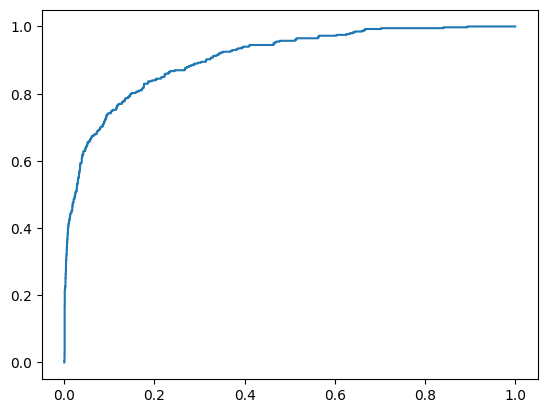

In [19]:
from matplotlib import pyplot as plt
plt.plot(fpr,tpr)

In [13]:
np.equal(np.where(np.array(ground_truth) == 1)[0],np.where(np.array(preds) >0)[0] )

/tmp/ipykernel_9011/1180606619.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.equal(np.where(np.array(ground_truth) == 1)[0],np.where(np.array(preds) >0)[0] )
/tmp/ipykernel_9011/1180606619.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.equal(np.where(np.array(ground_truth) == 1)[0],np.where(np.array(preds) >0)[0] )
/tmp/ipykernel_9011/1180606619.py:

RuntimeError: Boolean value of Tensor with more than one value is ambiguous